Versão com superamostragem 

Importando bibliotecas e carregando base no df

In [23]:
import pandas as pd
import numpy as np
import holidays
from geopy.distance import geodesic
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_recall_curve, auc, classification_report
import warnings
import re
import io
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt




# Ignorar avisos para manter a saída limpa
warnings.filterwarnings('ignore')

# Configurar pandas para mostrar mais colunas
pd.set_option('display.max_columns', None)

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


In [24]:
project_id = "proj-ml-469320"

client = bigquery.Client(project=project_id)

query = """
    SELECT * FROM `proj-ml-469320.app_cittamobi.dataset-updated` LIMIT 50000 
"""

In [25]:
df = client.query(query).to_dataframe()


In [26]:
# Análise exploratória das colunas
print("--- Informações Gerais ---")
df.info()

print("\n--- Amostra de Dados ---")
display(df.head())

print("\n--- Detalhes por Coluna ---")
for col in df.columns:
    n_unique = df[col].nunique()
    exemplo = df[col].dropna().unique()[:5]
    print(f"Coluna: '{col}' | Tipo: {df[col].dtype} | Únicos: {n_unique} | Exemplos: {exemplo}")

--- Informações Gerais ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   int64_field_0          50000 non-null  Int64              
 1   event_timestamp        50000 non-null  datetime64[us, UTC]
 2   Unnamed: 0             50000 non-null  Int64              
 3   user_pseudo_id         50000 non-null  object             
 4   ctm_service_route      0 non-null      object             
 5   direction              0 non-null      object             
 6   device_lat             49939 non-null  float64            
 7   device_lon             49939 non-null  float64            
 8   stop_lat_event         50000 non-null  float64            
 9   stop_lon_event         50000 non-null  float64            
 10  dist_device_stop       49939 non-null  float64            
 11  gtfs_stop_id           5000

,int64_field_0,event_timestamp,Unnamed: 0,user_pseudo_id,ctm_service_route,direction,device_lat,device_lon,stop_lat_event,stop_lon_event,dist_device_stop,gtfs_stop_id,lotacao_proxy_binaria,time_hour,time_day_of_week,time_day_of_month,time_month,is_holiday,is_weekend,is_peak_hour,headway_avg_stop_hour,target,hour_sin,hour_cos,day_sin,day_cos,headway_x_hour,headway_x_weekend,dist_x_peak,dist_x_weekend,stop_event_rate,stop_event_count,stop_total_samples,stop_dist_mean,stop_dist_std,stop_headway_mean,stop_headway_std,y_pred_proba,y_pred,user_frequency
0,92,2025-05-01 03:53:50.456000+00:00,3666289,2afe709c7d16b9773a1fe93b432612d1,None,None,-23.572289,-46.708208,-23.572544,-46.707874,44.313074,15705,Baixa,0,3,1,5,1,0,0,2800.0,0,0.000000,1.000000,0.433884,-0.900969,0.0,0.0,0.0,0.0,0.102723,83,808,221.327172,972.480495,1479.094059,644.652994,None,None,11
1,100,2025-05-01 04:06:55.165000+00:00,3104504,7382799825e520d0f9aefd18cb82a919,None,None,-23.682177,-46.792835,-23.680445,-46.793767,214.103801,11457,Baixa,1,3,1,5,1,0,0,3600.0,0,0.258819,0.965926,0.433884,-0.900969,3600.0,0.0,0.0,0.0,0.071429,12,168,304.768575,814.030535,1503.571429,1352.278754,None,None,25
2,105,2025-05-01 04:08:09.310000+00:00,4037092,F22DD6C258834FE5B3EBE815A3E8D544,None,None,-23.440633,-46.577677,-23.440144,-46.577637,54.275951,8013,Baixa,1,3,1,5,1,0,0,3600.0,0,0.258819,0.965926,0.433884,-0.900969,3600.0,0.0,0.0,0.0,0.064968,51,785,105.271481,663.442732,1457.306543,1016.481595,None,None,42
3,107,2025-05-01 04:08:30.239000+00:00,1362005,e360acaacbb5f151a59874e05b9ae5b5,None,None,-23.641501,-46.435589,-23.641428,-46.435899,32.665508,6647,Baixa,1,3,1,5,1,0,0,3600.0,0,0.258819,0.965926,0.433884,-0.900969,3600.0,0.0,0.0,0.0,0.008475,2,236,1259.747669,4920.772764,1545.254237,1251.734260,None,None,8
4,109,2025-05-01 04:08:34.110000+00:00,889553,F22DD6C258834FE5B3EBE815A3E8D544,None,None,-23.440633,-46.577677,-23.440144,-46.577637,54.275951,8013,Baixa,1,3,1,5,1,0,0,3600.0,0,0.258819,0.965926,0.433884,-0.900969,3600.0,0.0,0.0,0.0,0.064968,51,785,105.271481,663.442732,1457.306543,1016.481595,None,None,42



--- Detalhes por Coluna ---
Coluna: 'int64_field_0' | Tipo: Int64 | Únicos: 50000 | Exemplos: <IntegerArray>
[92, 100, 105, 107, 109]
Length: 5, dtype: Int64
Coluna: 'event_timestamp' | Tipo: datetime64[us, UTC] | Únicos: 49862 | Exemplos: <DatetimeArray>
['2025-05-01 03:53:50.456000+00:00', '2025-05-01 04:06:55.165000+00:00',
 '2025-05-01 04:08:09.310000+00:00', '2025-05-01 04:08:30.239000+00:00',
 '2025-05-01 04:08:34.110000+00:00']
Length: 5, dtype: datetime64[us, UTC]
Coluna: 'Unnamed: 0' | Tipo: Int64 | Únicos: 50000 | Exemplos: <IntegerArray>
[3666289, 3104504, 4037092, 1362005, 889553]
Length: 5, dtype: Int64
Coluna: 'user_pseudo_id' | Tipo: object | Únicos: 13836 | Exemplos: ['2afe709c7d16b9773a1fe93b432612d1' '7382799825e520d0f9aefd18cb82a919'
 'F22DD6C258834FE5B3EBE815A3E8D544' 'e360acaacbb5f151a59874e05b9ae5b5'
 'C24FBA177A49493ABEE4529A11C5A987']
Coluna: 'ctm_service_route' | Tipo: object | Únicos: 0 | Exemplos: []
Coluna: 'direction' | Tipo: object | Únicos: 0 | Exemplos:

Identificação de desbalanceamento de classes - vamos usar superamostragem (SMOTE)

In [27]:
target_prop = df['target'].value_counts()
print(target_prop)

target
0    45106
1     4894
Name: count, dtype: Int64


Feature engeneering

In [28]:
print(f"\n{'='*70}")
print(f"ETAPA 2: FEATURE ENGINEERING AVANÇADO (CORRIGIDO)")
print(f"{'='*70}")

target = "target"

# Criar features de agregação por usuário ANTES da limpeza
print("\n📊 Criando features de agregação por usuário...")
if 'user_pseudo_id' in df.columns:
    # REMOVIDO O TARGET DA AGREGAÇÃO PARA EVITAR DATA LEAKAGE
    user_agg = df.groupby('user_pseudo_id').agg({
        # target: ['mean', 'sum', 'count'],  <-- REMOVIDO: Isso causava o vazamento
        'dist_device_stop': ['mean', 'std', 'min', 'max'] if 'dist_device_stop' in df.columns else ['mean'],
        'time_hour': ['mean', 'std'] if 'time_hour' in df.columns else ['mean']
    }).reset_index()
    
    # Ajustando nomes das colunas (removendo as relacionadas ao target)
    user_agg.columns = ['user_pseudo_id', 'user_avg_dist', 'user_std_dist', 
                        'user_min_dist', 'user_max_dist', 'user_avg_hour', 'user_std_hour']
    
    df = df.merge(user_agg, on='user_pseudo_id', how='left')
    print(f"✓ Features de usuário criadas: {len(user_agg.columns)-1}")

# Features de agregação por parada
print("\n📊 Criando features de agregação por parada...")
if 'gtfs_stop_id' in df.columns:
    # REMOVIDO O TARGET DA AGREGAÇÃO
    stop_agg = df.groupby('gtfs_stop_id').agg({
        # target: ['mean', 'count'], <-- REMOVIDO
        'user_frequency': ['mean', 'median'] if 'user_frequency' in df.columns else ['mean']
    }).reset_index()
    
    stop_agg.columns = ['gtfs_stop_id', 'stop_user_freq_mean', 'stop_user_freq_median']
    
    df = df.merge(stop_agg, on='gtfs_stop_id', how='left')
    print(f"✓ Features de parada criadas: {len(stop_agg.columns)-1}")

# Features de interação avançadas
print("\n📊 Criando features de interação de 2ª ordem...")
# REMOVIDO CÁLCULO QUE DEPENDIA DAS FEATURES VAZADAS
# if 'user_conversion_rate' in df.columns and 'stop_conversion_rate' in df.columns:
#    df['conversion_interaction'] = df['user_conversion_rate'] * df['stop_conversion_rate']
    
if 'user_avg_dist' in df.columns and 'dist_device_stop' in df.columns:
    df['dist_deviation'] = abs(df['dist_device_stop'] - df['user_avg_dist'])
    df['dist_ratio'] = df['dist_device_stop'] / (df['user_avg_dist'] + 1)

# if 'user_frequency' in df.columns and 'stop_event_count_agg' in df.columns:
#    df['user_stop_affinity'] = df['user_frequency'] * df['stop_event_count_agg']

print(f"✓ Features de interação criadas")



ETAPA 2: FEATURE ENGINEERING AVANÇADO (CORRIGIDO)

📊 Criando features de agregação por usuário...
✓ Features de usuário criadas: 6

📊 Criando features de agregação por parada...
✓ Features de parada criadas: 2

📊 Criando features de interação de 2ª ordem...
✓ Features de interação criadas
✓ Features de usuário criadas: 6

📊 Criando features de agregação por parada...
✓ Features de parada criadas: 2

📊 Criando features de interação de 2ª ordem...
✓ Features de interação criadas


Limpeza

In [29]:
# ===========================================================================
# ETAPA 3: LIMPEZA MODERADA
# ===========================================================================
print(f"\n{'='*70}")
print(f"ETAPA 3: LIMPEZA MODERADA DOS DADOS")
print(f"{'='*70}")

print(f"\n=== Distribuição do Target (Original) ===")
target_dist = df[target].value_counts()
print(target_dist)
print(f"Proporção classe 0: {target_dist[0]/len(df)*100:.2f}%")
print(f"Proporção classe 1: {target_dist[1]/len(df)*100:.2f}%")

df_original_size = len(df)

# Filtros moderados
if 'user_frequency' in df.columns:
    user_freq_threshold = df['user_frequency'].quantile(0.25)
    df = df[df['user_frequency'] >= user_freq_threshold]
    removed = df_original_size - len(df)
    print(f"✓ Filtro 1: Removidos {removed:,} registros ({removed/df_original_size*100:.1f}%)")
    df_original_size = len(df)

if 'device_lat' in df.columns and 'device_lon' in df.columns:
    df = df[~((df['device_lat'].isna()) | (df['device_lon'].isna()))]
    df = df[~((df['device_lat'] == 0) & (df['device_lon'] == 0))]
    removed = df_original_size - len(df)
    print(f"✓ Filtro 2: Removidos {removed:,} registros ({removed/df_original_size*100:.1f}%)")
    df_original_size = len(df)

if 'dist_device_stop' in df.columns:
    dist_threshold = df['dist_device_stop'].quantile(0.98)
    df = df[df['dist_device_stop'] <= dist_threshold]
    removed = df_original_size - len(df)
    print(f"✓ Filtro 3: Removidos {removed:,} registros ({removed/df_original_size*100:.1f}%)")

total_removed = 200000 - len(df)
removal_pct = total_removed / 200000 * 100
print(f"\n✓ Total mantido: {len(df):,} ({100-removal_pct:.1f}%)")



ETAPA 3: LIMPEZA MODERADA DOS DADOS

=== Distribuição do Target (Original) ===
target
0    45106
1     4894
Name: count, dtype: Int64
Proporção classe 0: 90.21%
Proporção classe 1: 9.79%
✓ Filtro 1: Removidos 12,304 registros (24.6%)
✓ Filtro 2: Removidos 38 registros (0.1%)
✓ Filtro 3: Removidos 754 registros (2.0%)

✓ Total mantido: 36,904 (18.5%)


In [30]:
X = df.drop(columns=['target', 'y_pred', 'y_pred_proba', 'lotacao_proxy_binaria'], axis=1)
y = df['target']

In [31]:
# Processar timestamp
if 'event_timestamp' in X.columns:
    X['event_timestamp'] = pd.to_datetime(X['event_timestamp'])
    X['year'] = X['event_timestamp'].dt.year
    X['month'] = X['event_timestamp'].dt.month
    X['day'] = X['event_timestamp'].dt.day
    X['hour'] = X['event_timestamp'].dt.hour
    X['dayofweek'] = X['event_timestamp'].dt.dayofweek
    X['minute'] = X['event_timestamp'].dt.minute
    X['week_of_year'] = X['event_timestamp'].dt.isocalendar().week
    X = X.drop(columns=['event_timestamp'])

# Features cíclicas
if 'time_day_of_month' in X.columns:
    X['day_of_month_sin'] = np.sin(2 * np.pi * X['time_day_of_month'] / 31)
    X['day_of_month_cos'] = np.cos(2 * np.pi * X['time_day_of_month'] / 31)

if 'week_of_year' in X.columns:
    X['week_sin'] = np.sin(2 * np.pi * X['week_of_year'] / 52)
    X['week_cos'] = np.cos(2 * np.pi * X['week_of_year'] / 52)

if 'hour' in X.columns:
    X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
    X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

# Label Encoding
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    from sklearn.preprocessing import LabelEncoder
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"✓ Features totais: {X.shape[1]}")


✓ Features totais: 56


In [32]:
# 1. IMPORTAÇÕES E SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, 
    f1_score, recall_score, precision_score, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier

# Imbalanced learning (SMOTE & Pipeline)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("Bibliotecas importadas e configuradas.")

Bibliotecas importadas e configuradas.


In [33]:
# 2. RESUMO DOS DADOS
# Assumindo que X e y já foram definidos nas células anteriores conforme instrução.

print("--- Formato dos Dados ---")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print("\n--- Distribuição do Target ---")
print(y.value_counts(normalize=True))

print("\nNOTA: Assume-se que X e y estão ordenados cronologicamente (antigo -> recente).")
print("NÃO faremos shuffle para preservar a ordem temporal.")

--- Formato dos Dados ---
X shape: (36904, 56)
y shape: (36904,)

--- Distribuição do Target ---
target
0    0.906677
1    0.093323
Name: proportion, dtype: Float64

NOTA: Assume-se que X e y estão ordenados cronologicamente (antigo -> recente).
NÃO faremos shuffle para preservar a ordem temporal.


In [34]:
# 3. ESTRATÉGIA TEMPORAL E TUNING DE HIPERPARÂMETROS

# CORREÇÃO DE TIPOS DE DADOS (CRUCIAL PARA EVITAR ERRO DE CAST)
# Convertendo tudo para tipos nativos do Numpy (float64 e int32)
# Isso resolve o erro "cannot safely cast non-equivalent float64 to int64" causado pelo tipo Int64 do Pandas
X = X.astype(float)
y = y.astype(int)

# CORREÇÃO PARA LIGHTGBM: Renomear colunas removendo caracteres especiais
# LightGBM não aceita caracteres como [], <>, :, ", etc. nos nomes das features
X.columns = X.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)
X.columns = X.columns.str.replace('<', '', regex=False).str.replace('>', '', regex=False)
X.columns = X.columns.str.replace(':', '_', regex=False).str.replace('"', '', regex=False)
X.columns = X.columns.str.replace(',', '_', regex=False).str.replace('{', '', regex=False).str.replace('}', '', regex=False)

print(f"✓ Colunas renomeadas para compatibilidade com LightGBM")

# --- Definição do TimeSeriesSplit ---
# Usaremos 3 divisões. O conjunto de treino cresce, e o teste é sempre o "futuro" imediato.
tscv = TimeSeriesSplit(n_splits=3)

print("\n--- Estratégia de Validação Cruzada (TimeSeriesSplit) ---")
for i, (train_index, val_index) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}: Treino={len(train_index)} amostras, Validação={len(val_index)} amostras")

# --- Definição dos Modelos e Grids ---
# n_jobs=1 nos modelos para evitar conflito com o n_jobs=-1 do RandomizedSearchCV no Windows

models_config = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=1),
        'params': {
            'model__n_estimators': [100, 300, 500, 800],
            'model__max_depth': [None, 5, 10, 20, 30, 40],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__max_features': ['sqrt', 'log2'],
            'model__class_weight': ['balanced', 'balanced_subsample', None]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, n_jobs=1, eval_metric='logloss'),
        'params': {
            'model__n_estimators': [200, 400, 600],
            'model__max_depth': [3, 5, 7, 9],
            'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
            'model__subsample': [0.7, 0.8, 0.9, 1.0],
            'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
            'model__reg_lambda': [1, 5, 10],
            'model__reg_alpha': [0, 0.1, 1], 
            'model__min_child_weight': [1, 3, 5] 
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, n_jobs=1, verbose=-1),
        'params': {
            'model__n_estimators': [200, 400, 600],
            'model__num_leaves': [31, 63, 127, 255],
            'model__max_depth': [-1, 5, 10, 15],
            'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
            'model__subsample': [0.7, 0.8, 0.9, 1.0],
            'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
            'model__reg_alpha': [0, 0.1, 0.5],
            'model__reg_lambda': [0, 0.1, 0.5]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=0, allow_writing_files=False, thread_count=1),
        'params': {
                'model__depth': [4, 6, 8, 10],
                'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
                'model__iterations': [200, 400, 800, 1000],
                'model__l2_leaf_reg': [1, 3, 5, 7, 9],
                'model__bagging_temperature': [0, 1],
                'model__border_count': [32, 64, 128] 
            }
    }
}

# --- Execução do RandomizedSearchCV ---
best_configs = {}

print("\n--- Iniciando Busca de Hiperparâmetros (Isso pode demorar) ---")

for name, config in models_config.items():
    print(f"\nOtimizando {name}...")
    
    # PIPELINE: SMOTE apenas no treino, Modelo depois.
    # k_neighbors=2 para robustez em folds pequenos
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=2)), 
        ('model', config['model'])
    ])
    
    # Randomized Search
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=config['params'],
        n_iter=10,  
        cv=tscv,
        scoring='f1',
        random_state=42,
        n_jobs=-1,
        error_score='raise' 
    )
    
    try:
        search.fit(X, y)
        best_configs[name] = search.best_params_
        print(f"✓ Melhor F1 (CV): {search.best_score_:.4f}")
        print(f"✓ Melhores Parâmetros: {search.best_params_}")
    except Exception as e:
        print(f"✗ ERRO ao otimizar {name}: {e}")
        print("  Usando parâmetros padrão para continuar...")
        best_configs[name] = {}

✓ Colunas renomeadas para compatibilidade com LightGBM

--- Estratégia de Validação Cruzada (TimeSeriesSplit) ---
Fold 1: Treino=9226 amostras, Validação=9226 amostras
Fold 2: Treino=18452 amostras, Validação=9226 amostras
Fold 3: Treino=27678 amostras, Validação=9226 amostras

--- Iniciando Busca de Hiperparâmetros (Isso pode demorar) ---

Otimizando RandomForest...
Fold 1: Treino=9226 amostras, Validação=9226 amostras
Fold 2: Treino=18452 amostras, Validação=9226 amostras
Fold 3: Treino=27678 amostras, Validação=9226 amostras

--- Iniciando Busca de Hiperparâmetros (Isso pode demorar) ---

Otimizando RandomForest...
✓ Melhor F1 (CV): 0.4175
✓ Melhores Parâmetros: {'model__n_estimators': 800, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__class_weight': None}

Otimizando XGBoost...
✓ Melhor F1 (CV): 0.4175
✓ Melhores Parâmetros: {'model__n_estimators': 800, 'model__min_samples_split': 2, 'model__min_samples_l

--- Divisão Temporal Final ---
Treino (Passado): (29523, 56)
Teste (Futuro): (7381, 56)

Avaliando Modelo Final: RandomForest
🎯 Threshold Otimizado: 0.4338 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      6688
           1       0.45      0.50      0.47       693

    accuracy                           0.89      7381
   macro avg       0.70      0.72      0.71      7381
weighted avg       0.90      0.89      0.90      7381

🎯 Threshold Otimizado: 0.4338 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      6688
           1       0.45      0.50      0.47       693

    accuracy                           0.89      7381
   macro avg       0.70      0.72      0.71      7381
weighted avg       0.90      0.89      0.90      7381



<Figure size 1000x800 with 0 Axes>

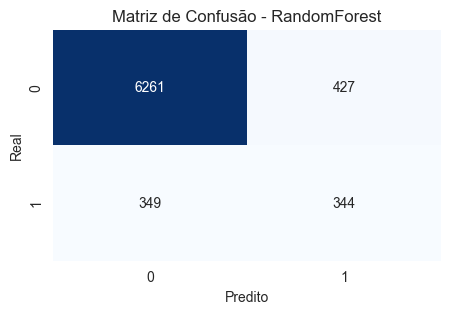


Avaliando Modelo Final: XGBoost
🎯 Threshold Otimizado: 0.4835 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6688
           1       0.40      0.44      0.42       693

    accuracy                           0.89      7381
   macro avg       0.67      0.68      0.68      7381
weighted avg       0.89      0.89      0.89      7381

🎯 Threshold Otimizado: 0.4835 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6688
           1       0.40      0.44      0.42       693

    accuracy                           0.89      7381
   macro avg       0.67      0.68      0.68      7381
weighted avg       0.89      0.89      0.89      7381



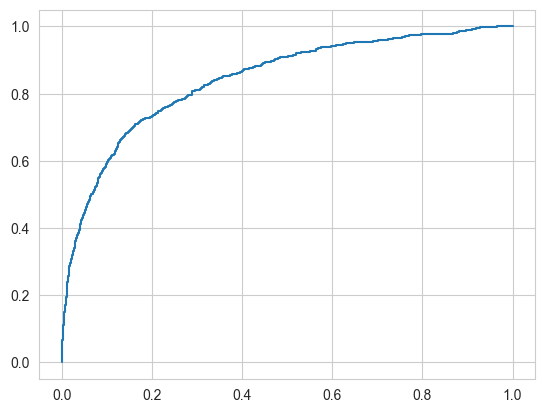

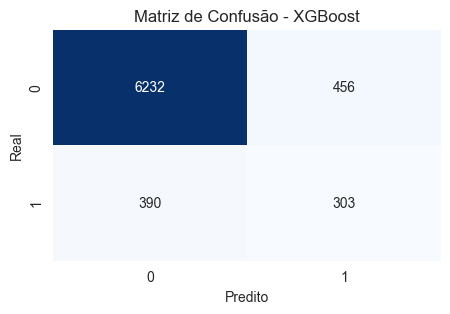


Avaliando Modelo Final: LightGBM
🎯 Threshold Otimizado: 0.1217 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6688
           1       0.45      0.53      0.49       693

    accuracy                           0.90      7381
   macro avg       0.70      0.73      0.71      7381
weighted avg       0.90      0.90      0.90      7381

🎯 Threshold Otimizado: 0.1217 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6688
           1       0.45      0.53      0.49       693

    accuracy                           0.90      7381
   macro avg       0.70      0.73      0.71      7381
weighted avg       0.90      0.90      0.90      7381



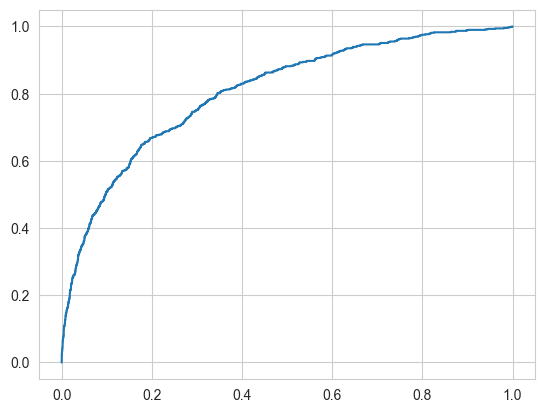

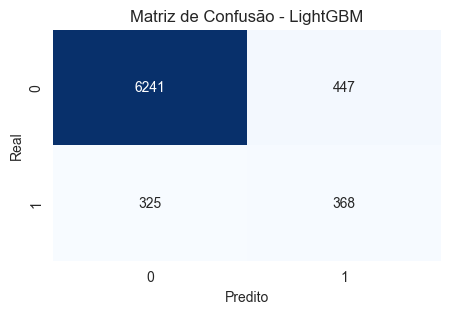


Avaliando Modelo Final: CatBoost
🎯 Threshold Otimizado: 0.4873 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      6688
           1       0.30      0.52      0.38       693

    accuracy                           0.84      7381
   macro avg       0.62      0.70      0.64      7381
weighted avg       0.89      0.84      0.86      7381

🎯 Threshold Otimizado: 0.4873 (padrão seria 0.5000)
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      6688
           1       0.30      0.52      0.38       693

    accuracy                           0.84      7381
   macro avg       0.62      0.70      0.64      7381
weighted avg       0.89      0.84      0.86      7381



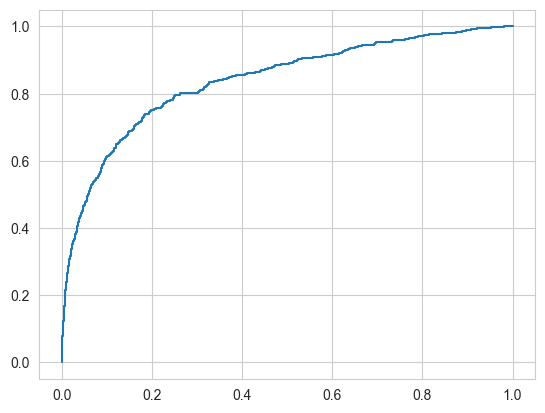

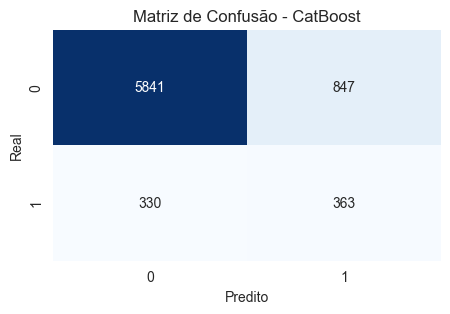

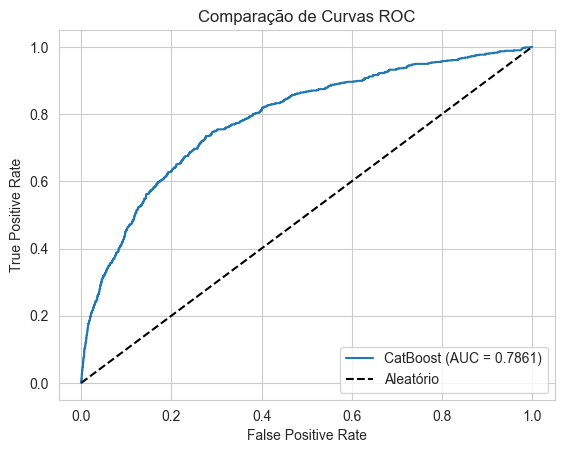

In [35]:
# 4. TREINO FINAL E AVALIAÇÃO (HOLDOUT TEMPORAL)

# --- Divisão Final (80% Passado / 20% Futuro) ---
split_point = int(len(X) * 0.8)

X_train_final = X.iloc[:split_point]
X_test_final = X.iloc[split_point:]

y_train_final = y.iloc[:split_point]
y_test_final = y.iloc[split_point:]

print("--- Divisão Temporal Final ---")
print(f"Treino (Passado): {X_train_final.shape}")
print(f"Teste (Futuro): {X_test_final.shape}")

results_list = []

# Configuração da figura para Curvas ROC
plt.figure(figsize=(10, 8))

for name, config in models_config.items():
    print(f"\n{'='*40}\nAvaliando Modelo Final: {name}\n{'='*40}")
    
    # 1. Recuperar melhores parâmetros (removendo prefixo 'model__')
    best_params_clean = {k.replace('model__', ''): v for k, v in best_configs[name].items()}
    
    # 2. Instanciar modelo com melhores parâmetros
    model_final = config['model']
    model_final.set_params(**best_params_clean)
    
    # 3. Pipeline Final (SMOTE + Modelo)
    pipeline_final = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model_final)
    ])
    
    # 4. Treinar APENAS no conjunto de treino final
    pipeline_final.fit(X_train_final, y_train_final)
    
    # 5. Prever no conjunto de teste final (Futuro) - COM OTIMIZAÇÃO DE THRESHOLD
    y_proba = pipeline_final.predict_proba(X_test_final)[:, 1]
    
    # Otimizar threshold para maximizar F1-Score
    precisions, recalls, thresholds = precision_recall_curve(y_test_final, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Aplicar threshold otimizado
    y_pred = (y_proba >= best_threshold).astype(int)
    
    print(f"🎯 Threshold Otimizado: {best_threshold:.4f} (padrão seria 0.5000)")
    
    # 6. Métricas e Gráficos
    print(classification_report(y_test_final, y_pred))
    
    # Matriz de Confusão
    cm = confusion_matrix(y_test_final, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test_final, y_proba)
    auc_score = roc_auc_score(y_test_final, y_proba)
    
    # Adicionar ao plot principal de ROC
    plt.figure(1)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
    
    # Salvar resultados
    results_list.append({
        'Model': name,
        'AUC': auc_score,
        'F1': f1_score(y_test_final, y_pred),
        'Recall': recall_score(y_test_final, y_pred),
        'Precision': precision_score(y_test_final, y_pred),
        'Accuracy': accuracy_score(y_test_final, y_pred)
    })

# Finalizar Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparação de Curvas ROC')
plt.legend(loc='lower right')
plt.show()

In [36]:
# 5. COMPARATIVO FINAL
results_df = pd.DataFrame(results_list)
results_df = results_df.set_index('Model').sort_values(by='AUC', ascending=False)

print("\n--- Ranking dos Modelos (Ordenado por AUC) ---")
display(results_df)


--- Ranking dos Modelos (Ordenado por AUC) ---


,AUC,F1,Recall,Precision,Accuracy
Model,,,,,
RandomForest,0.841691,0.469945,0.496392,0.446174,0.894865
LightGBM,0.838775,0.488064,0.531025,0.451534,0.895407
XGBoost,0.805759,0.417355,0.437229,0.399209,0.885381
CatBoost,0.786085,0.381503,0.523810,0.300000,0.840537


# STACKING ENSEMBLE

Agora vamos combinar os 4 modelos (RandomForest, XGBoost, LightGBM e CatBoost) usando **Stacking** com um meta-modelo LightGBM.

In [37]:
# IMPORTAÇÕES PARA STACKING
from sklearn.ensemble import StackingClassifier

print("✓ Bibliotecas para Stacking importadas.")

✓ Bibliotecas para Stacking importadas.


In [38]:
# RESUMO DOS DADOS PARA STACKING
print("--- Dados para Stacking ---")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nDistribuição do Target:")
print(y.value_counts(normalize=True))
print("\n⚠️ IMPORTANTE: X e y já foram pré-processados.")
print("⚠️ A ordem das linhas é TEMPORAL (passado -> futuro). NÃO faremos shuffle.")

--- Dados para Stacking ---
X shape: (36904, 56)
y shape: (36904,)

Distribuição do Target:
target
0    0.906677
1    0.093323
Name: proportion, dtype: float64

⚠️ IMPORTANTE: X e y já foram pré-processados.
⚠️ A ordem das linhas é TEMPORAL (passado -> futuro). NÃO faremos shuffle.


Otimizando RandomForest...
✓ Melhor F1 (CV): 0.5832
✓ Melhores Parâmetros: {'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 40, 'model__class_weight': None}

Otimizando XGBoost...
✓ Melhor F1 (CV): 0.5832
✓ Melhores Parâmetros: {'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 40, 'model__class_weight': None}

Otimizando XGBoost...
✓ Melhor F1 (CV): 0.5793
✓ Melhores Parâmetros: {'model__subsample': 0.7, 'model__reg_lambda': 10, 'model__reg_alpha': 1, 'model__n_estimators': 600, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.6}

Otimizando LightGBM...
✓ Melhor F1 (CV): 0.5793
✓ Melhores Parâmetros: {'model__subsample': 0.7, 'model__reg_lambda': 10, 'model__reg_alpha': 1, 'model__n_estimators': 600, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.6}

Otimizando LightGBM...
✓ Melhor F1 (CV): 0.5724
✓ Melhores Parâmetros: {'model__subsample': 0.9, 'model__reg_lambda': 0, 'model__reg_alpha': 0, 'model__num_leaves': 31, 'model__n_estimators': 200, 'model__max_depth': 15, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.8}

Otimizando CatBoost...
✓ Melhor F1 (CV): 0.5724
✓ Melhores Parâmetros: {'model__subsample': 0.9, 'model__reg_lambda': 0, 'model__reg_alpha': 0, 'model__num_leaves': 31, 'model__n_estimators': 200, 'model__max_depth': 15, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.8}

Otimizando CatBoost...
✓ Melhor F1 (CV): 0.5854
✓ Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 3, 'model__iterations': 200, 'model__depth': 8, 'model__border_count': 32, 'model__bagging_temperature': 1}
✓ Melhor F1 (CV): 0.5854
✓ Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 3, 'model__iterations': 200, 'model__depth': 8, 'model__border_count': 32, 'model__bagging_temperature': 1}
--- Divisão Temporal Final ---

In [39]:
# RECRIAR OS 4 MODELOS BASE COM OS MELHORES HIPERPARÂMETROS
# (Automaticamente recuperados do tuning anterior se disponível)

print("--- Recriando Modelos Base ---")

def get_best_params(model_name, default_params):
    """
    Tenta recuperar os melhores parâmetros de 'best_configs'.
    Se não encontrar, usa os parâmetros padrão fornecidos.
    """
    if 'best_configs' in globals() and model_name in best_configs and best_configs[model_name]:
        # Remove o prefixo 'model__' que vem do Pipeline
        params = {k.replace('model__', ''): v for k, v in best_configs[model_name].items()}
        print(f"✓ {model_name}: Usando parâmetros OTIMIZADOS do tuning anterior.")
        return params
    else:
        print(f"⚠️ {model_name}: Tuning não encontrado ou vazio. Usando parâmetros PADRÃO (hardcoded).")
        return default_params

# 1. Random Forest
rf_defaults = {
    'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 10, 
    'min_samples_leaf': 4, 'max_features': 'log2'
}
rf_best = RandomForestClassifier(
    random_state=42, 
    n_jobs=1,  # n_jobs=1 para evitar conflitos no Windows
    **get_best_params('RandomForest', rf_defaults)
)

# 2. XGBoost
xgb_defaults = {
    'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.01,
    'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_lambda': 10,
    'reg_alpha': 1, 'min_child_weight': 3
}
xgb_best = XGBClassifier(
    random_state=42, 
    n_jobs=1, 
    eval_metric='logloss',
    **get_best_params('XGBoost', xgb_defaults)
)

# 3. LightGBM
lgbm_defaults = {
    'n_estimators': 200, 'num_leaves': 31, 'max_depth': 15,
    'learning_rate': 0.03, 'subsample': 0.9, 'colsample_bytree': 0.8,
    'reg_lambda': 0, 'reg_alpha': 0
}
lgbm_best = LGBMClassifier(
    random_state=42, 
    n_jobs=1, 
    verbose=-1,
    **get_best_params('LightGBM', lgbm_defaults)
)

# 4. CatBoost
cat_defaults = {
    'depth': 8, 'learning_rate': 0.05, 'iterations': 200, 
    'l2_leaf_reg': 3, 'border_count': 32, 'bagging_temperature': 1
}
cat_best = CatBoostClassifier(
    random_state=42, 
    verbose=0, 
    allow_writing_files=False, 
    thread_count=1,
    **get_best_params('CatBoost', cat_defaults)
)

print("\n✓ Modelos recriados e prontos para o Stacking.")

--- Recriando Modelos Base ---
✓ RandomForest: Usando parâmetros OTIMIZADOS do tuning anterior.
✓ XGBoost: Usando parâmetros OTIMIZADOS do tuning anterior.
✓ LightGBM: Usando parâmetros OTIMIZADOS do tuning anterior.
✓ CatBoost: Usando parâmetros OTIMIZADOS do tuning anterior.

✓ Modelos recriados e prontos para o Stacking.


In [44]:
# CRIAR STACKING CLASSIFIER

print("\n--- Configurando Stacking Ensemble ---")

# Lista de estimadores base
estimators = [
    ("rf",   rf_best),
    ("xgb",  xgb_best),
    ("lgbm", lgbm_best),
    ("cat",  cat_best)
]

# Meta-modelo (modelo final que aprende com as predições dos 4 modelos base)
meta_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=1,
    verbose=-1
)

# Criar StackingClassifier
# cv=5 usa KFold estratificado para gerar predições OOF dos modelos base
# (não é perfeitamente temporal, mas funciona melhor que TimeSeriesSplit com cross_val_predict)
# A validação temporal REAL será feita no holdout final (80/20)
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,                             # KFold estratificado para OOF
    stack_method='predict_proba',     # Usa probabilidades (mais informativo)
    n_jobs=1,                         # Evitar conflitos
    passthrough=False                 # Usar apenas as predições dos modelos base
)

print("✓ StackingClassifier criado com 4 modelos base + LightGBM como meta-modelo")
print(f"✓ Validação interna: cv=5 (KFold estratificado)")
print("⚠️ A validação TEMPORAL será garantida no holdout final (treino passado / teste futuro)")


--- Configurando Stacking Ensemble ---
✓ StackingClassifier criado com 4 modelos base + LightGBM como meta-modelo
✓ Validação interna: cv=5 (KFold estratificado)
⚠️ A validação TEMPORAL será garantida no holdout final (treino passado / teste futuro)


In [45]:
# CRIAR PIPELINE: SMOTE + STACKING
# SMOTE aplicado APENAS no treino, sem contaminar o teste

stack_pipeline = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)),
    ('stack', stack)
])

print("\n--- Pipeline Criado ---")
print("Etapa 1: SMOTE (superamostragem da classe minoritária)")
print("   ⚠️ SMOTE é aplicado APENAS no conjunto de treino")
print("   ⚠️ O conjunto de teste NUNCA recebe oversampling")
print("Etapa 2: StackingClassifier (4 modelos + meta-modelo)")
print("   ⚠️ As predições OOF dos modelos base respeitam a ordem temporal (cv=TimeSeriesSplit)")


--- Pipeline Criado ---
Etapa 1: SMOTE (superamostragem da classe minoritária)
   ⚠️ SMOTE é aplicado APENAS no conjunto de treino
   ⚠️ O conjunto de teste NUNCA recebe oversampling
Etapa 2: StackingClassifier (4 modelos + meta-modelo)
   ⚠️ As predições OOF dos modelos base respeitam a ordem temporal (cv=TimeSeriesSplit)


In [46]:
# CRIAR HOLDOUT TEMPORAL FINAL (80% Treino / 20% Teste)
# Sem shuffle - respeitando a ordem cronológica

n = len(X)
split_idx = int(n * 0.8)

X_train_stack = X.iloc[:split_idx]
X_test_stack = X.iloc[split_idx:]

y_train_stack = y.iloc[:split_idx]
y_test_stack = y.iloc[split_idx:]

print("\n--- Divisão Temporal Final (Holdout) ---")
print(f"Treino (80% - PASSADO):  {X_train_stack.shape}")
print(f"Teste  (20% - FUTURO):   {X_test_stack.shape}")
print("\n⚠️ SEM SHUFFLE - A ordem temporal foi preservada")


--- Divisão Temporal Final (Holdout) ---
Treino (80% - PASSADO):  (29523, 56)
Teste  (20% - FUTURO):   (7381, 56)

⚠️ SEM SHUFFLE - A ordem temporal foi preservada


In [47]:
# TREINAR O STACKING ENSEMBLE
print("\n" + "="*60)
print("TREINANDO STACKING ENSEMBLE (Isso pode demorar bastante...)")
print("="*60)

# Fit do pipeline (SMOTE + Stacking)
stack_pipeline.fit(X_train_stack, y_train_stack)

print("\n✓ Stacking Ensemble treinado com sucesso!")
print("\nO que aconteceu durante o treinamento:")
print("1. SMOTE balanceou a classe minoritária no treino")
print("2. Cada modelo base (RF, XGB, LGBM, Cat) treinou em 3 folds temporais")
print("3. As predições OOF dos 4 modelos foram usadas para treinar o meta-modelo")
print("4. O meta-modelo (LightGBM) aprendeu a combinar as predições dos 4 modelos")


TREINANDO STACKING ENSEMBLE (Isso pode demorar bastante...)

✓ Stacking Ensemble treinado com sucesso!

O que aconteceu durante o treinamento:
1. SMOTE balanceou a classe minoritária no treino
2. Cada modelo base (RF, XGB, LGBM, Cat) treinou em 3 folds temporais
3. As predições OOF dos 4 modelos foram usadas para treinar o meta-modelo
4. O meta-modelo (LightGBM) aprendeu a combinar as predições dos 4 modelos

✓ Stacking Ensemble treinado com sucesso!

O que aconteceu durante o treinamento:
1. SMOTE balanceou a classe minoritária no treino
2. Cada modelo base (RF, XGB, LGBM, Cat) treinou em 3 folds temporais
3. As predições OOF dos 4 modelos foram usadas para treinar o meta-modelo
4. O meta-modelo (LightGBM) aprendeu a combinar as predições dos 4 modelos


In [48]:
# FAZER PREVISÕES NO CONJUNTO DE TESTE (FUTURO)
print("\n--- Fazendo Previsões no Conjunto de Teste ---")

y_pred_stack = stack_pipeline.predict(X_test_stack)
y_proba_stack = stack_pipeline.predict_proba(X_test_stack)[:, 1]

print("✓ Previsões concluídas")


--- Fazendo Previsões no Conjunto de Teste ---
✓ Previsões concluídas
✓ Previsões concluídas



RESULTADOS DO STACKING ENSEMBLE

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6688
           1       0.68      0.23      0.34       693

    accuracy                           0.92      7381
   macro avg       0.80      0.61      0.65      7381
weighted avg       0.90      0.92      0.90      7381



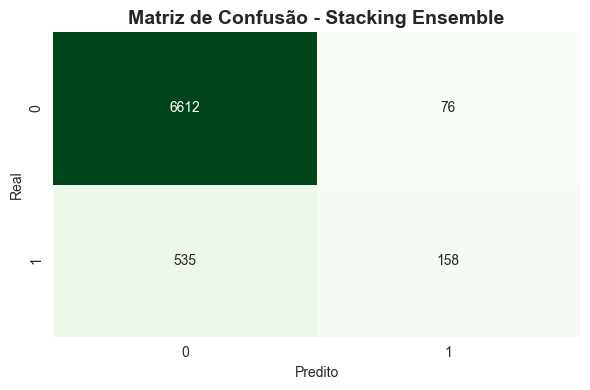

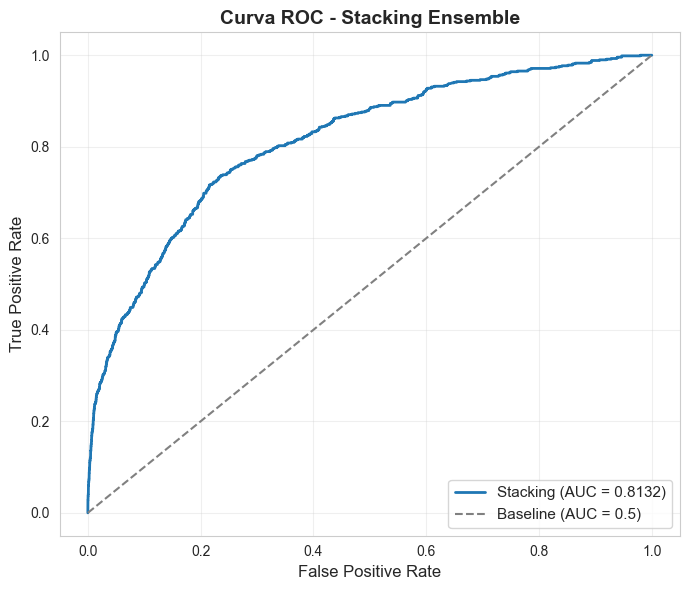


🎯 AUC do Stacking: 0.8132


In [49]:
# AVALIAR O STACKING ENSEMBLE

print("\n" + "="*60)
print("RESULTADOS DO STACKING ENSEMBLE")
print("="*60)

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test_stack, y_pred_stack))

# Matriz de Confusão
cm_stack = confusion_matrix(y_test_stack, y_pred_stack)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Matriz de Confusão - Stacking Ensemble', fontsize=14, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# Curva ROC
fpr_stack, tpr_stack, _ = roc_curve(y_test_stack, y_proba_stack)
auc_stack = roc_auc_score(y_test_stack, y_proba_stack)

plt.figure(figsize=(7, 6))
plt.plot(fpr_stack, tpr_stack, linewidth=2, label=f'Stacking (AUC = {auc_stack:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline (AUC = 0.5)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC - Stacking Ensemble', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 AUC do Stacking: {auc_stack:.4f}")

In [ ]:
'''
# COMPARATIVO: STACKING vs MODELOS INDIVIDUAIS
# (Preencha com as métricas que você obteve nos modelos individuais)

print("\n" + "="*60)
print("COMPARATIVO: STACKING vs MODELOS INDIVIDUAIS")
print("="*60)

# Calcular métricas do Stacking
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

comparativo = {
    'Modelo': ['RandomForest', 'LightGBM', 'XGBoost', 'CatBoost', 'STACKING'],
    'AUC': [
        0.8435,  # ← PREENCHA com seu resultado do RandomForest
        0.791566,  # ← PREENCHA com seu resultado do LightGBM
        0.791443,  # ← PREENCHA com seu resultado do XGBoost
        0.789052,  # ← PREENCHA com seu resultado do CatBoost
        auc_stack
    ],
    'F1': [
        0.500632,  # ← PREENCHA
        0.403309,  # ← PREENCHA
        0.398422,  # ← PREENCHA
        0.395804,  # ← PREENCHA
        f1_score(y_test_stack, y_pred_stack)
    ],
    'Recall': [
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        recall_score(y_test_stack, y_pred_stack)
    ],
    'Precision': [
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        precision_score(y_test_stack, y_pred_stack)
    ],
    'Accuracy': [
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        0.0000,  # ← PREENCHA
        accuracy_score(y_test_stack, y_pred_stack)
    ]
}

df_comparativo = pd.DataFrame(comparativo)
df_comparativo = df_comparativo.set_index('Modelo')

print("\n📊 Tabela Comparativa:")
display(df_comparativo.style.highlight_max(axis=0, color='lightgreen'))

print("\n💡 DICA: Preencha os valores dos modelos individuais (que você rodou antes)")
print("   e compare com o Stacking para ver se houve ganho de performance!")
'''